In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from make_datasets import create_dataset

### Making syntethic data

In [2]:
%%time

dataset = {'acc_var': [], 'acc_max': [], 'Velocity': [], 'Length': [], 'Deltas': [], 'IRI': []}

N = 300
vels = np.linspace(10, 40, N)
length = 50
sample_rate = 100
#vel = 25
dx = 0.1

profiles = {}
for prof_type in ['A', 'B', 'C']:
    profiles[prof_type] =  {
        "num_profiles": N,
        "deltas": [dx]*N,
        "lengths": [length]*N,
        "seeds": np.arange(N),
        "velocities": vels, 
        "sample_rates": [sample_rate]*N
        }

rps, accs, iris = create_dataset(profiles)


dataset['Velocity'] = list(vels) * 3
dataset['Deltas'] = dx
dataset['Length'] = length


dataset['IRI'] = iris

for p in accs:
    dataset['acc_var'].append(np.var(p))
    dataset['acc_max'].append(np.max(p))


dataset = pd.DataFrame(dataset)
    


CPU times: user 1min 26s, sys: 53.1 s, total: 2min 19s
Wall time: 37.5 s


In [3]:
dataset.head()

,acc_var,acc_max,Velocity,Length,Deltas,IRI
0,0.170230,3.565651,10.000000,50,0.1,2.597274
1,0.100043,0.714267,10.100334,50,0.1,2.124137
2,0.105082,2.652706,10.200669,50,0.1,1.914638
3,0.128463,1.252770,10.301003,50,0.1,2.570281
4,0.073721,0.876858,10.401338,50,0.1,1.777799


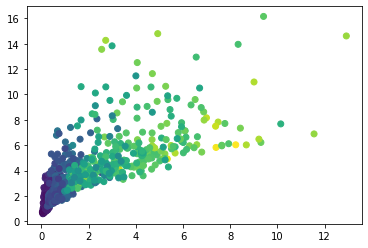

In [4]:
plt.scatter(dataset['acc_var'], dataset['acc_max'], c = dataset['IRI'])

### Training

In [5]:
X = dataset.values[:, :3]
y = dataset['IRI'].values

X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.2)
X.shape

(720, 3)

In [ ]:
# wouldn't it be nice to restrict the output to be between 0 and say 11? tf doesn't think so...
from keras import backend as K

def relu10(x):
    if x <= 11:
        return K.relu(x)
    else:
        return 11 

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

models1 = {'neurons_layer1': [], 'k': [], 'error': []}

es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.001, patience = 10, verbose=0)


for n1 in [2, 4, 8, 16, 32, 64, 128, 256, 564]:
    
    k = 0
    for train_index,test_index in KFold(5).split(X):
        
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        
        model1 = Sequential([
            Dense(n1, activation = 'sigmoid', kernel_initializer='he_normal'),
            Dense(1, activation = 'linear', kernel_initializer='he_normal') 
        ])
        model1.compile(loss = 'mean_squared_error', optimizer = 'adam')
       
        history = model1.fit(X_train, y_train, validation_data = (X_valid, y_valid), 
                             epochs = 1000, batch_size = 500, verbose=0, callbacks = [es])

        print(n1, k, history.history['val_loss'][-1])
        models1['neurons_layer1'].append(n1)
        models1['k'].append(k)
        models1['error'].append(history.history['val_loss'][-1])
        
        k += 1
        
    print()
    
models1 = pd.DataFrame(models1)

2 0 8.479363441467285
2 1 2.5783305168151855
2 2 9.170891761779785
2 3 15.889911651611328
2 4 5.554978370666504

4 0 5.271590232849121
4 1 4.858781814575195
4 2 1.007124423980713
4 3 1.7062833309173584
4 4 1.0012272596359253

8 0 1.0106940269470215
8 1 0.6766365766525269
8 2 1.2424328327178955
8 3 1.1957656145095825
8 4 0.6556053161621094

16 0 0.6293732523918152
16 1 0.6562834978103638
16 2 0.4359016716480255
16 3 0.4443903863430023
16 4 0.41385141015052795

32 0 0.6309981346130371
32 1 0.3690541982650757
32 2 0.4157947301864624
32 3 0.4869794249534607
32 4 0.4536842703819275

64 0 0.5320672988891602
64 1 0.34326308965682983
64 2 0.3295327425003052
64 3 0.45766013860702515
64 4 0.4554550349712372

128 0 0.4708666205406189
128 1 0.2973495125770569
128 2 0.31052106618881226
128 3 0.46490907669067383
128 4 0.4413113594055176

256 0 0.4782739281654358
256 1 0.2779054045677185
256 2 0.2867799401283264
256 3 0.5418910980224609
256 4 0.4383369982242584

564 0 0.41587314009666443
564 1 0.2677

In [12]:
f = {'k': lambda x: 10, 'error': np.var, 'avg_error': np.mean}
models1['avg_error'] = models1['error']
models_groupped = models1.groupby(by = 'neurons_layer1').aggregate(f)
models_groupped

,k,error,avg_error
neurons_layer1,,,
2,10,7.741199,7.644125
4,10,10.184776,4.016271
8,10,0.320282,1.387810
16,10,0.009035,0.524174
32,10,0.006578,0.464746
64,10,0.008602,0.415213
128,10,0.014765,0.404158
256,10,0.017163,0.401869
564,10,0.011411,0.386691


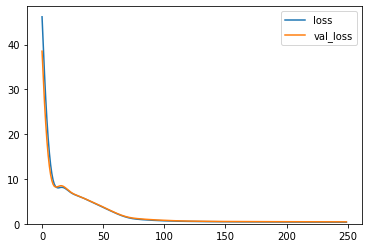

0.4370911419391632

In [16]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.ylim((0, max(history.history['val_loss']) + 10))
plt.show()

history.history['val_loss'][-1]


In [20]:
evaluate = pd.DataFrame({'Preds': model1.predict(X_valid).reshape(len(X_valid)), 'y_true': y_valid})
evaluate['Preds_mapped'] = evaluate['Preds'].apply(lambda x: x if x > 0 and x < 11 else 11)
evaluate['Difference'] = np.absolute(evaluate['Preds_mapped']-evaluate['y_true'])
evaluate.loc[evaluate['Difference'] > 1]




,Preds,y_true,Preds_mapped,Difference
3,9.072009,10.281124,9.072009,1.209115
18,4.108047,5.220596,4.108047,1.112549
35,8.378351,10.441192,8.378351,2.062841
38,9.668070,8.345414,9.668070,1.322656
47,9.369489,7.497895,9.369489,1.871594
55,11.111679,7.981176,11.000000,3.018824
56,9.793056,11.005334,9.793056,1.212279
70,8.588519,9.608107,8.588519,1.019588
79,11.049050,9.434977,11.000000,1.565023
81,8.521260,7.233253,8.521260,1.288007


In [9]:
models2 = {'neurons_layer1': [], 'neurons_layer2': [], 'k': [], 'error': []}

es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.001, patience = 10, verbose=0)

for n1 in [2, 4, 8, 16, 32, 64, 128, 256, 564]:
    for n2 in [2, 4, 8, 16, 32, 64, 128, 256, 564]:

        k = 0
        for train_index,test_index in KFold(5).split(X):

            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = y[train_index], y[test_index]

            model1 = Sequential([
                Dense(n1, activation = 'relu', kernel_initializer='he_normal'),
                Dense(n2, activation = 'relu', kernel_initializer='he_normal'),
                Dense(1, activation = 'linear', kernel_initializer='he_normal') 
            ])
            model1.compile(loss = 'mean_squared_error', optimizer = 'adam')

            history = model1.fit(X_train, y_train, validation_data = (X_valid, y_valid), 
                                 epochs = 1000, batch_size = 500, verbose=0, callbacks = [es])

            #print(n1, n2, k, history.history['val_loss'][-1])
            models2['neurons_layer1'].append(n1)
            models2['neurons_layer2'].append(n2)
            models2['k'].append(k)
            models2['error'].append(history.history['val_loss'][-1])

            k += 1

        #print()
    
models2 = pd.DataFrame(models2)

2 2 0 3.0658111572265625
2 2 1 17.45435333251953


KeyboardInterrupt: 

In [ ]:
models2

In [ ]:
import pickle
pickle.dump(models2, open("models2", "wb"))

In [ ]:
X_test[34]